In [1]:
import psi4
import matplotlib.pyplot as plt
from pathlib import Path
from scf_guess.io import load_molecule
from scf_guess.metrics import f_score

In [2]:
psi4.set_memory("4 GiB")
psi4.set_options(
    {
        "BASIS": "pcseg-0",  # Small basis set for now (right column of Lehtola 2006 Table 1 uses the pcseg-0 basis)
        "SCF_TYPE": "PK",  # Disable density fitting for now
        "STABILITY_ANALYSIS": "CHECK",  # Check that the SCF iteration actually converged to a minimum
    }
)
psi4.core.be_quiet()


  Memory set to   4.000 GiB by Python driver.


In [3]:
data_dir = Path("../data/test_data/geometries/")
# I purposefully picked a molecule without any symmetry
mol = load_molecule(data_dir / "W4-17" / "ch4.xyz")

In [4]:
# Run Hartree-Fock calculation to obtain a converged density
e, final_wfn = psi4.energy(name="hf", molecule=mol, return_wfn=True)
print(f"Final energy: {e} Ha")
psi4.core.clean()

Final energy: -40.082045095324034 Ha


In [5]:
def build_guess_wfn(guess="SAD"):
    psi4.set_options({"GUESS": guess})
    # Build the guess density
    basis = psi4.core.BasisSet.build(mol)
    ref_wfn = psi4.core.Wavefunction.build(mol, basis)
    guess_wfn = psi4.driver.scf_wavefunction_factory(
        name="hf", ref_wfn=ref_wfn, reference="RHF"
    )
    guess_wfn.form_H()
    guess_wfn.form_Shalf()
    guess_wfn.guess()

    psi4.core.clean()
    return guess_wfn

/tmp/ipykernel_335508/4285592146.py:11: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[irrep][0].imshow(guess_wfn.S().to_array(dense=False)[irrep], **imshow_kwargs)
/tmp/ipykernel_335508/4285592146.py:11: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[irrep][0].imshow(guess_wfn.S().to_array(dense=False)[irrep], **imshow_kwargs)
/tmp/ipykernel_335508/4285592146.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[irrep][1].imshow(guess_wfn.Da().to_array(dense=False)[irrep], **imshow_kwargs)
/tmp/ipykernel_335508/4285592146.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[irrep][1].imshow(guess_wfn.Da().to_array(dense=False)[irrep], **imshow_kwargs)
/tmp/ipykernel_335508/4285592146.py:17: Us

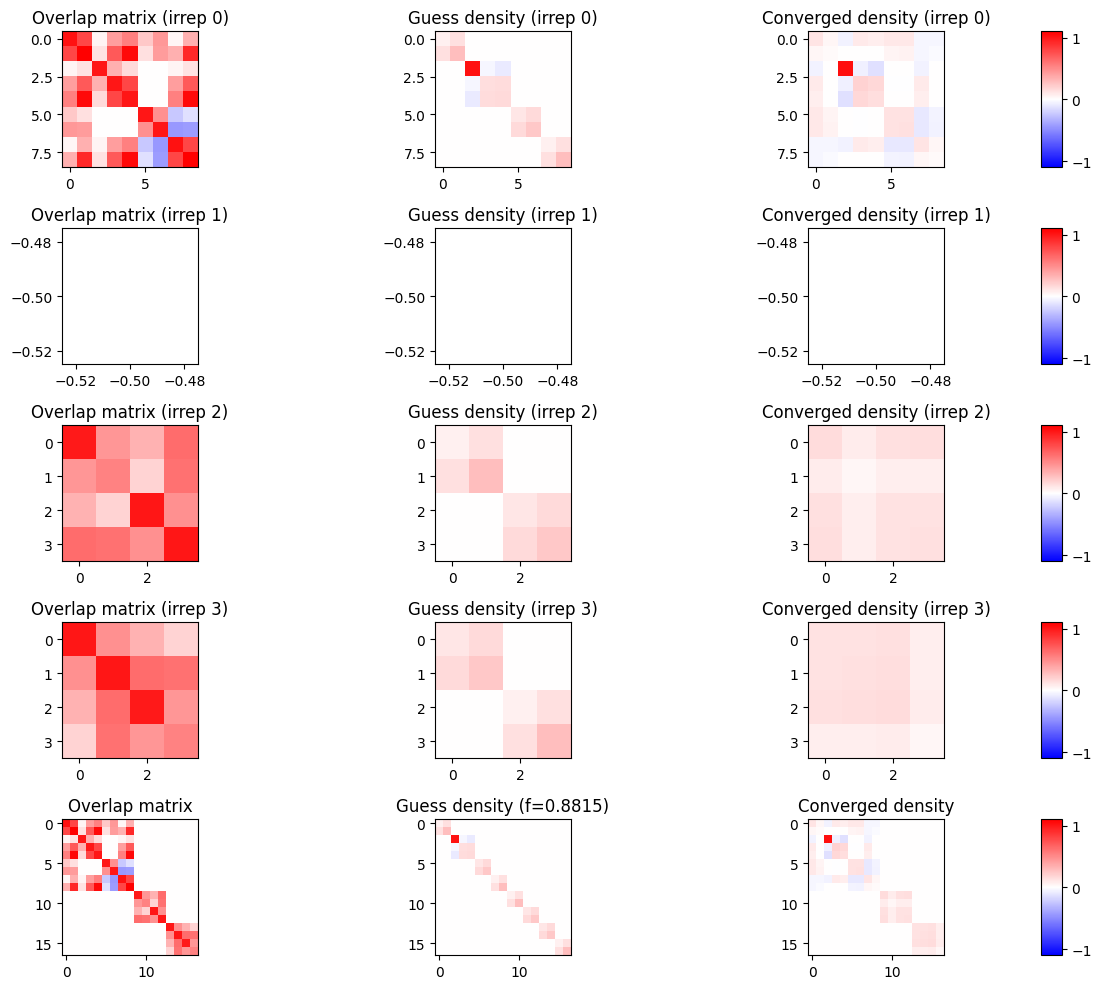

In [6]:
guess_wfn = build_guess_wfn(
    guess="SAD",  # Feel free to change this to inspect the various guess densities
)

irreps = guess_wfn.S().nirrep()

imshow_kwargs = dict(vmin=-1.1, vmax=1.1, cmap="bwr")
fig, ax = plt.subplots(figsize=(12, (irreps+1)*2), ncols=4, nrows=irreps+1, width_ratios=[1, 1, 1, 0.05])

for irrep in range(irreps):
    ax[irrep][0].imshow(guess_wfn.S().to_array(dense=False)[irrep], **imshow_kwargs)
    ax[irrep][0].set_title(f"Overlap matrix (irrep {irrep})")

    ax[irrep][1].imshow(guess_wfn.Da().to_array(dense=False)[irrep], **imshow_kwargs)
    ax[irrep][1].set_title(f"Guess density (irrep {irrep})")

    p = ax[irrep][2].imshow(final_wfn.Da().to_array(dense=False)[irrep], **imshow_kwargs)
    ax[irrep][2].set_title(f"Converged density (irrep {irrep})")

    plt.colorbar(p, cax=ax[irrep][3])

ax[-1][0].imshow(guess_wfn.S().to_array(dense=True), **imshow_kwargs)
ax[-1][0].set_title("Overlap matrix")

ax[-1][1].imshow(guess_wfn.Da().to_array(dense=True), **imshow_kwargs)
ax[-1][1].set_title(
    f"Guess density (f={f_score(guess_wfn.S().to_array(dense=True), final_wfn.Da().to_array(dense=True), guess_wfn.Da().to_array(dense=True)):.4f})"
)

p = ax[-1][2].imshow(final_wfn.Da().to_array(dense=True), **imshow_kwargs)
ax[-1][2].set_title("Converged density")

plt.colorbar(p, cax=ax[-1][3])
plt.tight_layout()

# Different initial guesses

Lets try to reproduce the corresponding row from Supporting Information Table S5:

| Molecule     | GWH   | CORE  | SAD   | SADNO | HUCKEL | GSZ   | LDA-X | CAP-X | CHA-X |  
| ------------ | ----- | ----- | ----- | ----- | ------ | ----- | ----- | ----- | ----- |
| ch4          | 0.405 | 0.618 | 0.881 | 0.966 | 0.972  | 0.907 | 0.965 | 0.964 | 0.965 |

In [7]:
# All available initial guess options in psi4
guesses = ["GWH", "CORE", "SAD", "SADNO", "HUCKEL", "SAP", "SAPGAU"]
for guess in guesses:
    guess_wfn = build_guess_wfn(guess=guess)
    f = f_score(final_wfn.S().to_array(dense=True), final_wfn.Da().to_array(dense=True), guess_wfn.Da().to_array(dense=True))
    print(f"{guess:>8s}: {f:.3f}")

     GWH: 0.872
    CORE: 0.618
     SAD: 0.881
   SADNO: 0.966
  HUCKEL: 0.972
     SAP: 0.952
  SAPGAU: 0.980


For some reason we get very different results for GWH (suspecting an error in the original paper) and slightly different results for HUCKEL. The two SAP variants can probably not be compared to the SAP results from the paper as it is unclear which implementation is used.